In [68]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get list of all CSV files in the directory
list_of_files = list(Path("../../logs/breaking_points_fainder").rglob("*.csv"))

df_latest = pd.DataFrame()

for file_path in list_of_files:
    # Read the CSV file
    file_path = str(file_path)
    print(f"Processing file: {file_path}")
    temp_df = pd.read_csv(file_path)

    # Append to the main DataFrame
    df_latest = pd.concat([df_latest, temp_df], ignore_index=True)
# "timestamp,fainder_mode,filter_size_wrong,filter_size_right,filter_size,filter_size_wrong_doc,filter_size_right_doc,filter_size_doc,execution_time,execution_time_first,num_results_first,num_results,query, num_workers

df_latest["query"] = df_latest["query"].str.replace(
    r"kw\('[^']*'\)\s+AND\s+", "", regex=True
)

os.makedirs("excecution", exist_ok=True)

Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250604_154241.csv
Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250603_134925.csv
Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250606_100747.csv
Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250606_101802.csv
Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250604_151031.csv
Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250606_102900.csv
Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250606_100820.csv
Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250604_143404.csv


/tmp/ipykernel_38288/3313662426.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_latest = pd.concat([df_latest, temp_df], ignore_index=True)
/tmp/ipykernel_38288/3313662426.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_latest = pd.concat([df_latest, temp_df], ignore_index=True)


/tmp/ipykernel_38288/1970160231.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


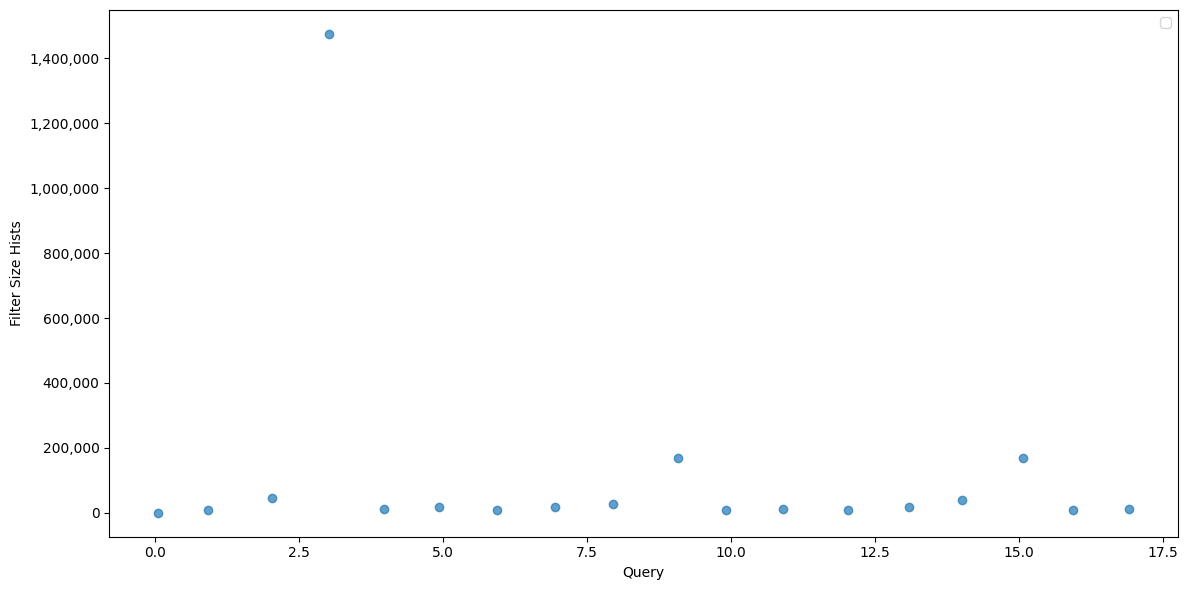

num_workers: 27, grouped:                          query filter_size
0          col(pp(0.1; ge; 1))     3168716
1     col(pp(0.1; ge; 100000))     3168716
2   col(pp(0.1; ge; 10000000))     3168716
3          col(pp(0.1; le; 1))     3168716
4     col(pp(0.1; le; 100000))     3168716
5   col(pp(0.1; le; 10000000))     3072048
6          col(pp(0.5; ge; 1))     3168716
7     col(pp(0.5; ge; 100000))     3168716
8   col(pp(0.5; ge; 10000000))     3168716
9          col(pp(0.5; le; 1))     3168716
10    col(pp(0.5; le; 100000))     3168716
11  col(pp(0.5; le; 10000000))     3168716
12         col(pp(0.9; ge; 1))     3168716
13    col(pp(0.9; ge; 100000))     3168716
14  col(pp(0.9; ge; 10000000))     3168716
15         col(pp(0.9; le; 1))     3168716
16    col(pp(0.9; le; 100000))     3168716
17  col(pp(0.9; le; 10000000))     3168716
num_workers: 0, grouped:                          query filter_size
0          col(pp(0.1; ge; 1))      880859
1     col(pp(0.1; ge; 100000))     1165564
2  

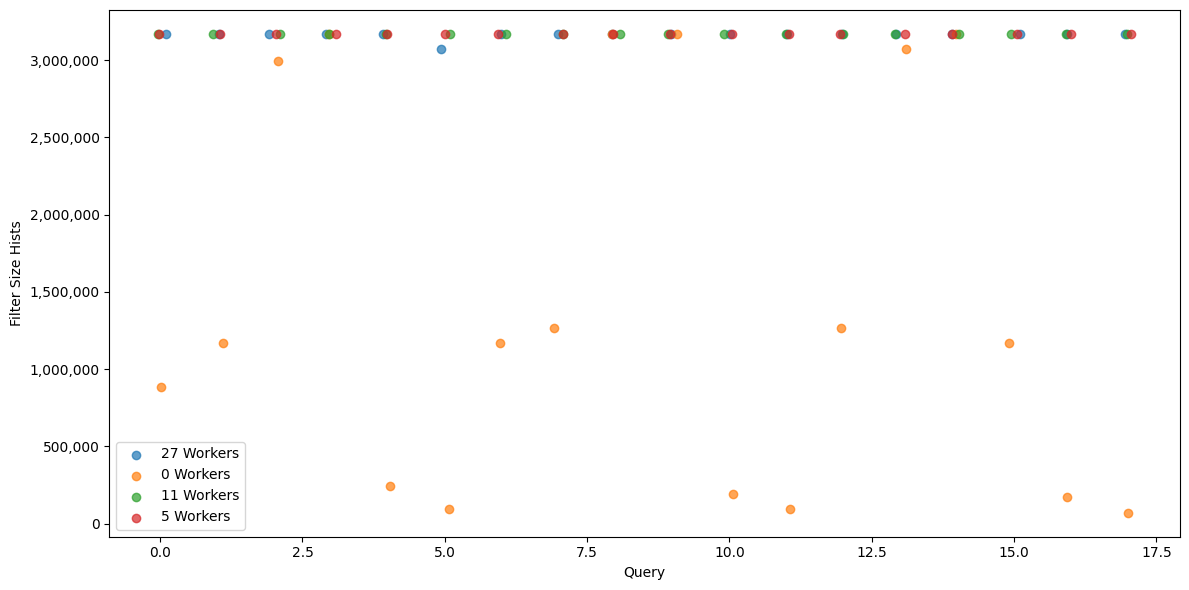

In [69]:
# plot breaking points per query per num_workers as points in two plots
import numpy as np

fainder_modes = df_latest["fainder_mode"].unique()
for fainder_mode in fainder_modes:
    df_filtered = df_latest[df_latest["fainder_mode"] == fainder_mode]

    # Create a figure with just one subplot
    fig, ax = plt.subplots(figsize=(12, 6))

    if fainder_mode == "exact":
        for num_workers in df_filtered["num_workers"].unique():
            df_worker = df_filtered[df_filtered["num_workers"] == num_workers]
            # Group by query and find the max filter size
            grouped = df_worker.groupby("query")["filter_size"].max().reset_index()
            print(f"num_workers: {num_workers}, grouped: {grouped}")
            # Plotting points instead of bars with transparency and jitter
            ax.scatter(
                grouped.index
                + np.random.uniform(
                    -0.1, 0.1, size=len(grouped.index)
                ),  # Add jitter to x-axis
                grouped["filter_size"],
                alpha=0.7,  # Add transparency
                label=f"{num_workers} Workers",
            )
    else:
        # For non-exact modes, we can ignore num_workers
        grouped = df_filtered.groupby("query")["filter_size"].max().reset_index()
        ax.scatter(
            grouped.index
            + np.random.uniform(
                -0.1, 0.1, size=len(grouped.index)
            ),  # Add jitter to x-axis
            grouped["filter_size"],
            alpha=0.7,  # Add transparency
        )

    # ax.set_title(f"Breaking Points for {fainder_mode} Mode - Filter Size Hists")
    ax.set_ylabel("Filter Size Hists")
    ax.set_xlabel("Query")
    ax.tick_params(axis="x")
    ax.legend()

    # Format y-axis with commas
    ax.get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: format(int(x), ","))
    )

    plt.tight_layout()
    plt.savefig(f"excecution/breaking_points_{fainder_mode}.png")
    plt.show()

[0, 5, 11, 27]


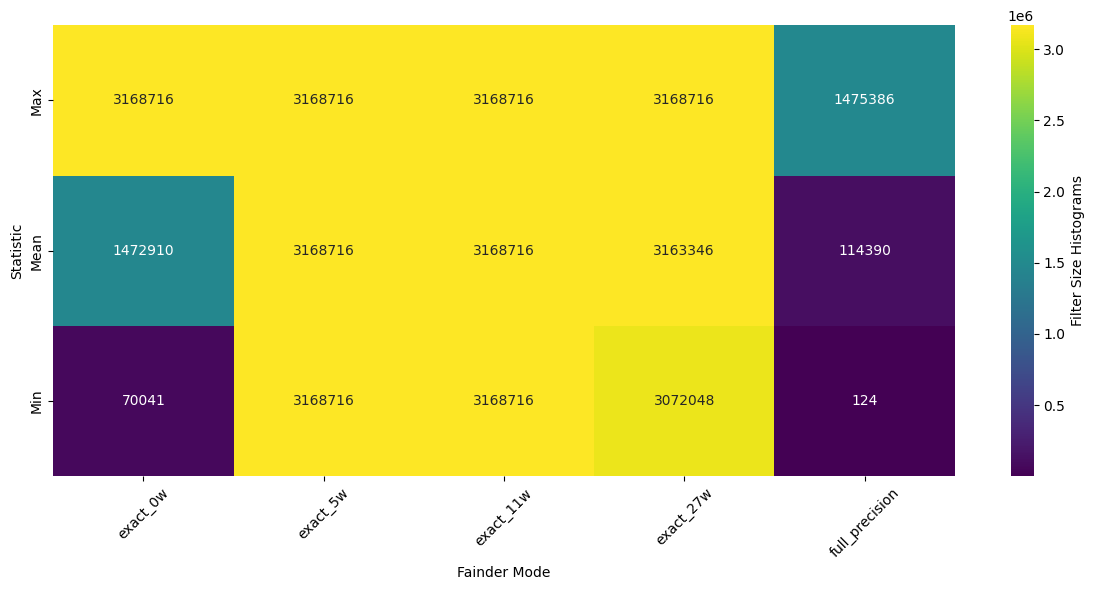

In [70]:
# Create a single heatmap showing min, mean, max of maximum filter sizes per query
import seaborn as sns

# Prepare aggregated data
agg_data = []

for fainder_mode in df_latest["fainder_mode"].unique():
    df_filtered = df_latest[df_latest["fainder_mode"] == fainder_mode]

    if fainder_mode == "exact":
        # For exact mode, group by num_workers
        num_workers = df_filtered["num_workers"].unique()
        # sort num_workers for consistent order in heatmap
        sorted_num_workers = sorted(num_workers)
        print(sorted_num_workers)
        for num_workers in sorted_num_workers:
            df_worker = df_filtered[df_filtered["num_workers"] == num_workers]
            # Get max filter_size per query, then calculate min, mean, max of those values
            max_per_query = df_worker.groupby("query")["filter_size"].max()
            min_val = max_per_query.min()
            mean_val = max_per_query.mean()
            max_val = max_per_query.max()

            agg_data.append(
                {
                    "fainder_mode": f"{fainder_mode}_{num_workers}w",
                    "metric": "Min",
                    "value": min_val,
                }
            )
            agg_data.append(
                {
                    "fainder_mode": f"{fainder_mode}_{num_workers}w",
                    "metric": "Mean",
                    "value": mean_val,
                }
            )
            agg_data.append(
                {
                    "fainder_mode": f"{fainder_mode}_{num_workers}w",
                    "metric": "Max",
                    "value": max_val,
                }
            )
    else:
        # For non-exact modes, aggregate all data
        # Get max filter_size per query, then calculate min, mean, max of those values
        max_per_query = df_filtered.groupby("query")["filter_size"].max()
        min_val = max_per_query.min()
        mean_val = max_per_query.mean()
        max_val = max_per_query.max()

        agg_data.append(
            {"fainder_mode": fainder_mode, "metric": "Min", "value": min_val}
        )
        agg_data.append(
            {"fainder_mode": fainder_mode, "metric": "Mean", "value": mean_val}
        )
        agg_data.append(
            {"fainder_mode": fainder_mode, "metric": "Max", "value": max_val}
        )

agg_df = pd.DataFrame(agg_data)

# Create a single heatmap
fig, ax = plt.subplots(figsize=(12, 6))

# Pivot data for heatmap
pivot_data = agg_df.pivot(index="metric", columns="fainder_mode", values="value")


# Custom sorting function for fainder modes with numbers
def sort_fainder_modes(column_names):
    """Sort fainder mode columns, putting exact modes with numbers in numerical order"""
    exact_modes = []
    other_modes = []

    for col in column_names:
        if col.startswith("exact_") and col.endswith("w"):
            # Extract the number from the column name
            try:
                num = int(col.split("_")[1].replace("w", ""))
                exact_modes.append((num, col))
            except ValueError:
                other_modes.append(col)
        else:
            other_modes.append(col)

    # Sort exact modes by number
    exact_modes.sort(key=lambda x: x[0])
    exact_mode_names = [col for _, col in exact_modes]

    # Sort other modes alphabetically
    other_modes.sort()

    return exact_mode_names + other_modes


# Reorder columns with proper sorting
sorted_columns = sort_fainder_modes(pivot_data.columns.tolist())
pivot_data = pivot_data[sorted_columns]

sns.heatmap(
    pivot_data,
    ax=ax,
    cmap="viridis",
    annot=True,
    fmt=".0f",
    cbar_kws={"label": "Filter Size Histograms"},
)

ax.set_xlabel("Fainder Mode")
ax.set_ylabel("Statistic")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(
    "excecution/breaking_points_filter_size_heatmap_aggregated.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [71]:
print("Current column order:")
print(pivot_data.columns.tolist())
print("Sorted column order:")
print(sorted_columns)

Current column order:
['exact_0w', 'exact_5w', 'exact_11w', 'exact_27w', 'full_precision']
Sorted column order:
['exact_0w', 'exact_5w', 'exact_11w', 'exact_27w', 'full_precision']
